# GRACE Data Windowing

This code processes the GRACE Total Water Storage (TWS) data by time step, calculating weighted LWE thickness and aggregating it for large hydrographic basins. It uses Dask for parallel processing and outputs the results as a CSV file with basin-level aggregations over time.

In [197]:
# Import necessary libraries for geospatial and data processing
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import dask_geopandas as dgpd
import dask.dataframe as dd
from dask import delayed, compute
import gc

# Function to calculate the area of a grid cell based on latitude
def cell_area(lat, lat_res=0.25, lon_res=0.25):
    """
    Calculate the area of a grid cell given its center latitude.
    
    Parameters:
    - lat: Latitude of the cell center
    - lat_res: Latitude resolution of the grid
    - lon_res: Longitude resolution of the grid
    
    Returns:
    - Area of the cell in square meters
    """
    R = 6371000  # Earth's average radius in meters
    lat_rad = np.radians(lat)
    lat_res_rad = np.radians(lat_res)
    lon_res_rad = np.radians(lon_res)
    area = (R**2) * lon_res_rad * (np.sin(lat_rad + lat_res_rad / 2) - np.sin(lat_rad - lat_res_rad / 2))
    return area  # in square meters

# Function to process each time index in parallel using Dask
@delayed
def process_time_index(time_index, lons, lats, tws, geometry, selected_basins_dask):
    """
    Process each time step to compute weighted LWE thickness and aggregate the data by basin.
    
    Parameters:
    - time_index: Index of the time step to process
    - lons: Array of longitudes
    - lats: Array of latitudes
    - tws: LWE thickness (TWS) data from GRACE
    - geometry: Points of lat/lon for spatial join
    - selected_basins_dask: Dask GeoDataFrame containing the selected basins
    
    Saves results to CSV after computing the aggregation for each time step.
    """
    # Extract LWE thickness data for the current time index
    variable_data = tws.isel(time=time_index).values.flatten()
    time_value = grace.coords['time'].values[time_index]

    # Create DataFrame with GRACE data for the current time index
    grace_df = pd.DataFrame({
        'lon': lon_flat,
        'lat': lat_flat,
        'lwe_thickness': variable_data,
        'time': time_value
    })
    
    # Adjust GRACE longitudes to range -180 to 180
    grace_df['lon'] = ((grace_df['lon'] + 180) % 360) - 180
    
    # Create geometries for spatial join
    grace_df['geometry'] = gpd.points_from_xy(grace_df['lon'], grace_df['lat'], crs="EPSG:4326")

    # Convert to GeoDataFrame
    grace_gdf = gpd.GeoDataFrame(grace_df, geometry='geometry', crs="EPSG:4326")
    
    # Convert to Dask GeoDataFrame for parallel processing
    grace_gdf_dask = dgpd.from_geopandas(grace_gdf, npartitions=8)

    # Perform spatial join with basins
    grace_with_basins_dask = dgpd.sjoin(grace_gdf_dask, selected_basins_dask, how='inner', predicate='within')

    # Calculate weighted LWE thickness based on cell area
    grace_with_basins_dask['cell_area'] = grace_with_basins_dask['lat'].apply(cell_area, meta=('lat', 'f8'))
    grace_with_basins_dask['weighted_lwe_thickness'] = grace_with_basins_dask['lwe_thickness'] * grace_with_basins_dask['cell_area']

    # Aggregate results by basin
    basin_aggregations_dask = grace_with_basins_dask.groupby(['index_right', 'time']).agg({
        'weighted_lwe_thickness': 'sum',
        'cell_area': 'sum',
        'area_m2' : 'mean'
    }).reset_index().compute()

    # Calculate aggregated LWE thickness
    basin_aggregations_dask['lwe_thickness_agg'] = basin_aggregations_dask['weighted_lwe_thickness'] / basin_aggregations_dask['cell_area']

    # Save intermediate result to CSV
    basin_aggregations_dask.to_csv(f"basin_aggregations_{time_index}.csv", index=False)

    print(f"Completed for time index {time_index + 1}...")

    # Free memory
    del grace_gdf_dask, grace_with_basins_dask, basin_aggregations_dask, grace_df, variable_data, time_value
    gc.collect()

# Load GRACE dataset (TWS)
print("Loading GRACE dataset...")
grace = xr.open_dataset("Datos/CSR_GRACE_GRACE-FO_RL0602_Mascons_all-corrections.nc")
tws = grace['lwe_thickness']

# Extract coordinates once for use across all time indices
lons = grace.coords['lon'].values
lats = grace.coords['lat'].values
lon_grid, lat_grid = np.meshgrid(lons, lats)
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()
geometry = gpd.points_from_xy(lon_flat, lat_flat, crs="EPSG:4326")

# Load and select the largest basins based on area (95th percentile)
print("Loading basin shapefile...")
basins = gpd.read_file("Datos/WHYMAP_basins/whymap_GW_aquifers_v1_poly.shp")
basins = basins.to_crs(epsg=4326)
basins['geometry'] = basins['geometry'].apply(lambda geom: geom if geom.bounds[0] >= -180 and geom.bounds[2] <= 180 else geom)
basins['area_m2'] = basins.to_crs(epsg=3395)['geometry'].area
selected_basins = basins[basins['area_m2'] >= basins['area_m2'].quantile(0.95)]
selected_basins_dask = dgpd.from_geopandas(selected_basins.to_crs("EPSG:4326"), npartitions=8)
print("Loaded and selected basins based on area.")

# Start parallel processing with Dask for all time steps
print("Starting processing...")
tasks = [process_time_index(i, lons, lats, tws, geometry, selected_basins_dask) for i in range(len(grace.coords['time']))]
compute(*tasks)

# Combine results from all time steps and save to final CSV
print("Combining results from all time indices...")
final_df_list = [pd.read_csv(f"basin_aggregations_{i}.csv") for i in range(len(grace.coords['time']))]
final_df = pd.concat(final_df_list, ignore_index=True)
final_df.to_csv("final_basin_aggregations.csv", index=False)
print("Final aggregation complete. Results saved to 'final_basin_aggregations.csv'.")

Loading GRACE dataset...
Loading basin shapefile...
Loaded and selected basins based on area.
Starting processing...
Completed for time index 77...
Completed for time index 158...
Completed for time index 116...
Completed for time index 121...
Completed for time index 201...
Completed for time index 122...
Completed for time index 211...
Completed for time index 6...
Completed for time index 156...
Completed for time index 47...
Completed for time index 113...
Completed for time index 164...
Completed for time index 84...
Completed for time index 208...
Completed for time index 193...
Completed for time index 8...
Completed for time index 56...
Completed for time index 15...
Completed for time index 52...
Completed for time index 89...
Completed for time index 5...
Completed for time index 224...
Completed for time index 31...
Completed for time index 155...
Completed for time index 141...
Completed for time index 107...
Completed for time index 212...
Completed for time index 25...
Co

In [198]:
## Pivot the DataFrame
basin_df = final_df.pivot(index='time', columns='index_right', values='lwe_thickness_agg')
basin_df.reset_index(inplace=True)

In [199]:
basin_df.shape

(233, 173)

In [200]:
basin_df.head()

index_right,time,0,9,19,20,34,37,39,66,82,...,3404,3410,3411,3412,3413,3414,3415,3417,3420,3423
0,107.0,35.682990,38.987248,69.191215,33.677134,-0.043378,6.645263,16.579995,-1.631208,5.020133,...,9.510355,2.368805,3.915196,4.073391,5.820807,10.619357,14.230042,19.130266,8.804339,0.815126
1,129.5,42.884935,37.598804,65.835124,33.112559,0.803209,-4.622807,17.483923,-10.547043,-12.305306,...,11.440717,2.774641,2.064557,3.717258,6.900350,9.655698,15.069280,20.038457,5.354453,1.450520
2,227.5,29.405668,30.437546,37.330745,24.366665,7.704861,2.039836,17.870761,32.579143,-0.096138,...,-5.050047,1.269182,2.972073,-1.532077,-7.997307,-8.889215,0.995950,-9.165984,-8.058658,2.252535
3,258.0,30.811307,31.834355,39.608095,22.861751,10.437746,1.389576,12.994788,23.446734,-2.754050,...,-6.121785,0.360481,1.970204,-2.831803,-6.898306,-8.849053,-1.432903,-8.731687,-8.748455,3.081263
4,288.5,33.689495,32.327520,44.966517,23.614414,10.098095,2.292174,11.616842,33.282886,0.430785,...,-5.447098,2.332374,3.937938,-2.616873,-6.463842,-6.445910,-0.876289,-5.818636,-6.687354,2.874087


In [201]:
# Define the start date for the time reference (days since 2002-01-01)
start_date = np.datetime64('2002-01-01')

# Extract time values from the DataFrame, representing days since the start date
time_values = basin_df['time'].values

# Convert the time values into actual dates by adding the days to the start date
dates = pd.to_datetime(start_date + time_values.astype('timedelta64[D]'))

# Format the converted dates as 'DD-MM-YYYY' and update the 'time' column in the DataFrame
basin_df['time'] = pd.to_datetime(dates, format='%d-%m-%Y')

In [202]:
# List of missing months to fill gaps in the time series data
missing_months = ['2002-06-01', '2002-07-01', '2003-06-01', '2011-01-01',
               '2011-06-01', '2012-05-01', '2012-10-01', '2013-03-01',
               '2013-08-01', '2013-09-01', '2014-02-01', '2014-07-01',
               '2014-12-01', '2015-06-01', '2015-10-01', '2015-11-01',
               '2016-04-01', '2016-09-01', '2016-10-01', '2017-02-01',
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-08-01', '2018-09-01']

# Sort the original dataset chronologically by the 'time' column
basin_df = basin_df.sort_values('time').reset_index(drop=True)

# Ensure all column names are strings for consistency
basin_df.columns = basin_df.columns.astype('str')

# Convert the list of missing months to datetime format
missing_months = pd.to_datetime(missing_months)

# Create a new DataFrame for the missing months, with NaN for other columns
missing_df = pd.DataFrame({'time': missing_months})
missing_df = missing_df.assign(**{col: pd.NA for col in basin_df.columns if col != 'time'})

# Concatenate the original data with the missing months, and sort by time
basin_df = pd.concat([basin_df, missing_df], ignore_index=True).sort_values('time').reset_index(drop=True)

In [203]:
basin_df['month'] = basin_df['time'].dt.month
basin_df['year'] = basin_df['time'].dt.year

### We check if the missing values are correctly placed

<Axes: >

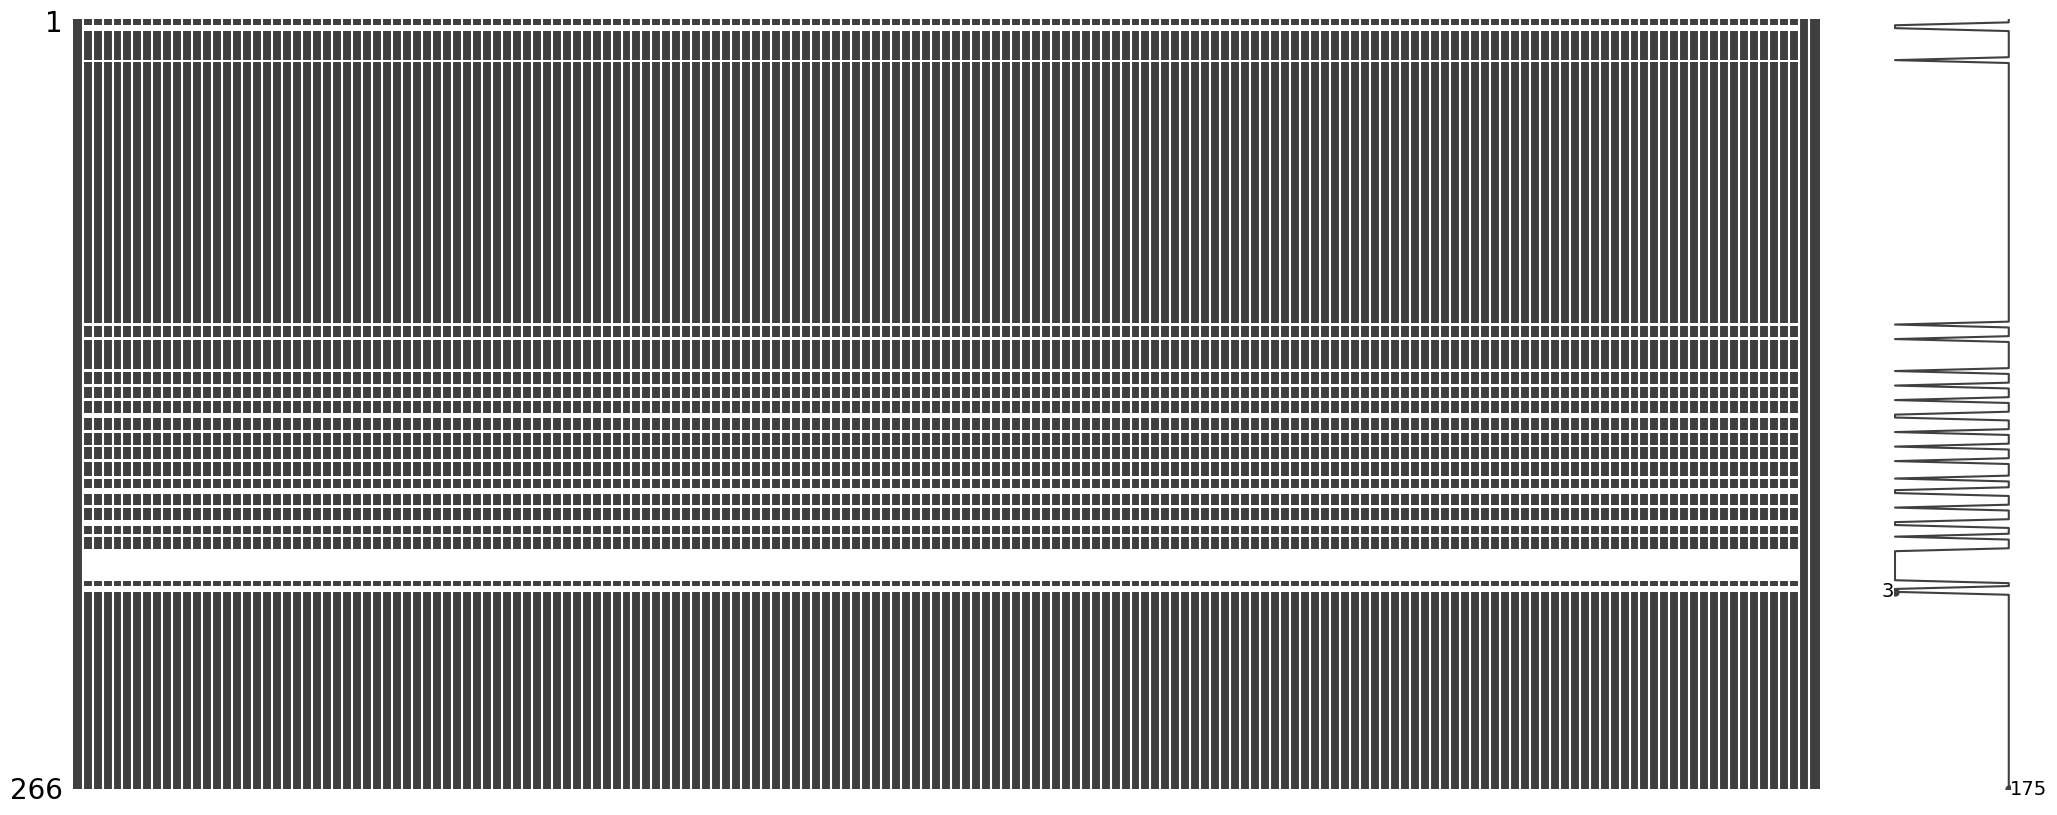

In [204]:
import missingno as msno
msno.matrix(basin_df)

In [205]:
basin_df[basin_df.duplicated(subset=['year', 'month'], keep=False)]

,time,0,9,19,20,34,37,39,66,82,...,3411,3412,3413,3414,3415,3417,3420,3423,month,year
114,2011-10-16,-45.422413,-79.280073,-66.417985,-60.796939,-39.866971,-15.673324,-50.510940,50.871933,-26.074876,...,-7.095259,-5.486310,-6.947798,-7.337312,-8.276325,-7.433858,-9.509195,-2.418697,10,2011
115,2011-10-31,-46.025751,-78.418371,-67.329112,-60.267552,-41.304935,-12.457623,-50.514582,62.493914,-19.936895,...,-7.639361,-5.299268,-5.379274,-6.398746,-7.507652,-4.959468,-8.647671,-2.306401,10,2011
156,2015-04-16,-66.448553,-106.570654,-80.100129,-84.965133,-44.617650,-7.319322,-72.731571,14.410416,-12.666023,...,-10.126922,-0.979989,3.944498,10.995413,10.757555,20.488730,10.417382,-9.101531,4,2015
157,2015-04-27,-65.750066,-102.852636,-80.700837,-86.237560,-44.542604,-3.089814,-74.982064,22.151521,-8.854499,...,-9.147135,-1.216877,3.831422,11.525323,13.011086,24.552737,7.761447,-8.130424,4,2015


In [206]:
# Remove observations at indices 115 and 157, as they don't correspond to measurements taken on the 16th (as expected)
basin_df = basin_df.drop([115, 157], errors='ignore').reset_index(drop=True)

In [207]:
basin_df.shape

(264, 175)

In [208]:
basin_df.to_csv('basin_df.csv', index=False)

In [223]:
basin_df = pd.read_csv('basin_df.csv')

### We check if the time series seem right

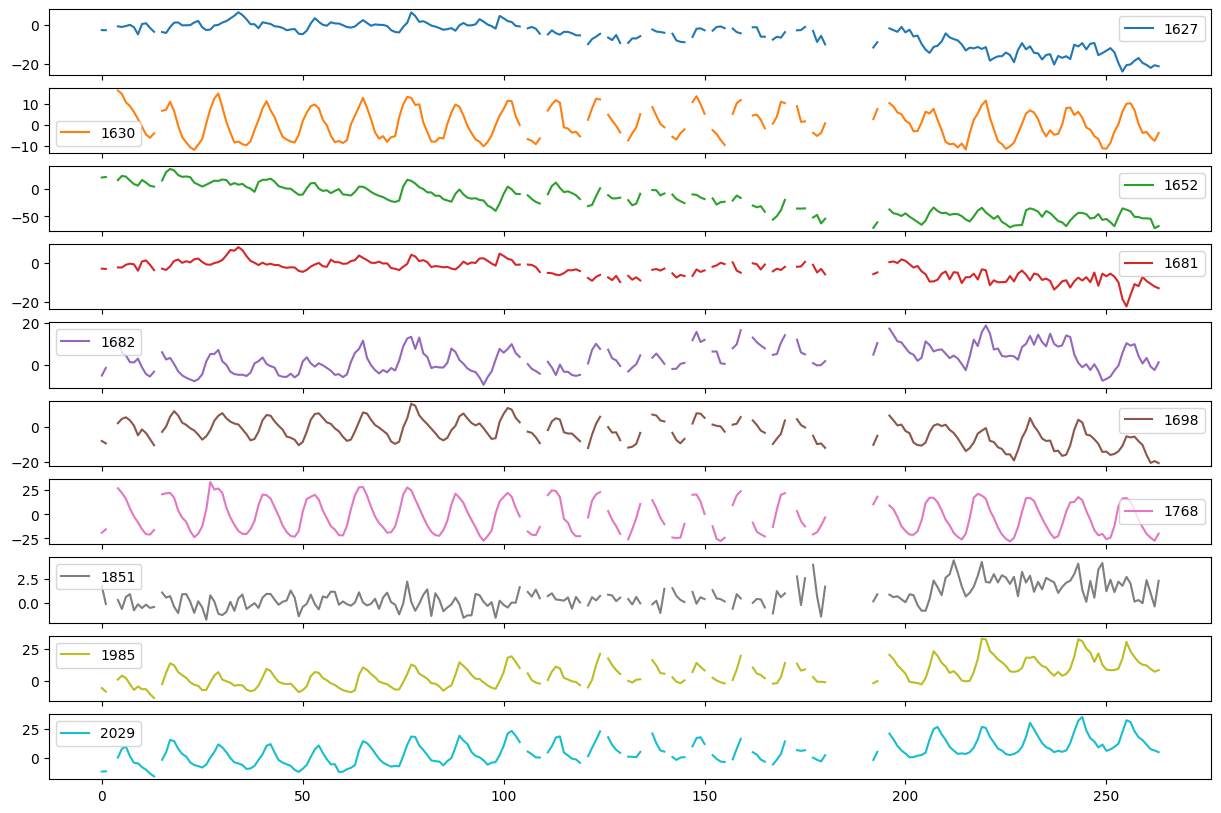

In [224]:
sample_columns = basin_df.columns[95:105]
basin_df[sample_columns].plot(subplots=True, layout=(10, 1), figsize=(15, 10))
plt.show()

In [225]:
def create_training_data(df, future_threshold=0.7, past_threshold=0.65, future_window=26, past_window=50):
    """
    Creates a DataFrame for training a time series prediction model, applying conditions on the number 
    of non-NaN values in both future and past windows.

    Parameters:
    df (pd.DataFrame): Original DataFrame with a 'datetime' column and location code columns.
    future_threshold (float): Minimum proportion of non-NaN values required in the future window.
    past_threshold (float): Minimum proportion of non-NaN values required in the past window.
    future_window (int): Size of the future window.
    past_window (int): Size of the past window.

    Returns:
    pd.DataFrame: DataFrame with lag variables (lag_p, lag_p-1, ..., lag_1) and step variables (step_1, step_2, ..., step_s) 
    for each location, as well as additional historical features.
    """
    
    # Initialize an empty DataFrame for the resulting dataset
    returned_df = pd.DataFrame()

    # Define column names for the past (lags) and future (steps)
    past_columns = [f'lag_{i}' for i in range(past_window, 0, -1)]
    future_columns = [f'step_{i}' for i in range(1, future_window + 1)]
    
    # Define additional feature column names (historical stats and others)
    extra_cols = ["id_loc", "datetime", "hist_mean", "hist_max", "hist_min", "hist_std", "hist_vc", 
                  "mean_past_year", "max_past_year", "min_past_year", "mean_past_quarter", "max_past_quarter", 
                  "min_past_quarter", "pct_diff_meanlast12_meanhist", 'otm_hist_0', 'otm_hist_1', 'otm_hist_2', 
                  'otm_hist_3', 'otm_hist_4', 'otm_hist_5', 'otm_hist_6', 'otm_hist_7', 'otm_hist_8', 'otm_hist_9', 
                  'otm_hist_10', 'otm_hist_11']

    # Iterate through each location column (ignoring the first column, assumed to be 'datetime')
    for i in range(1, df.shape[1]):  
        print("Processing location {}/{}".format(i, df.shape[1] - 1))
        
        # Loop through the data starting from the first valid index, considering both past and future windows
        for j in range(df.iloc[:, i].first_valid_index() + past_window, df.shape[0] - future_window):
            # Select the window of observations
            new_obs = df.iloc[(j-past_window):(j+future_window), i].copy()

            # Check if the past and future windows meet the non-NaN thresholds
            past_condition = sum(np.isnan(new_obs[:past_window])) <= (1-past_threshold)*past_window
            future_condition = sum(np.isnan(new_obs[-future_window:])) <= (1-future_threshold)*future_window

            # Proceed if both conditions are satisfied
            if past_condition and future_condition:
                # Impute missing values in the past window with the mean of the past window
                new_obs[:past_window] = new_obs[:past_window].fillna(new_obs[:past_window].mean())

                # Add additional features to the dataset (historical and ID variables)
                id_loc = pd.DataFrame({0: [df.columns[i]]})  # Location identifier
                datetime = pd.DataFrame({0: [df.iloc[j, 0]]})  # Date for the current observation
                hist_mean = pd.DataFrame({0: [df.iloc[:j, i].mean()]})  # Historical mean
                hist_max = pd.DataFrame({0: [df.iloc[:j, i].max()]})  # Historical maximum
                hist_min = pd.DataFrame({0: [df.iloc[:j, i].min()]})  # Historical minimum
                hist_std = pd.DataFrame({0: [df.iloc[:j, i].std()]})  # Historical standard deviation
                hist_vc = hist_std / hist_mean  # Historical variation coefficient
                mean_past_year = pd.DataFrame({0: [df.iloc[j-12:j, i].mean()]})  # Mean of the past year
                max_past_year = pd.DataFrame({0: [df.iloc[j-12:j, i].max()]})  # Maximum of the past year
                min_past_year = pd.DataFrame({0: [df.iloc[j-12:j, i].min()]})  # Minimum of the past year
                mean_past_quarter = pd.DataFrame({0: [df.iloc[j-3:j, i].mean()]})  # Mean of the past quarter
                max_past_quarter = pd.DataFrame({0: [df.iloc[j-3:j, i].max()]})  # Maximum of the past quarter
                min_past_quarter = pd.DataFrame({0: [df.iloc[j-3:j, i].min()]})  # Minimum of the past quarter
                pct_diff_meanlast12_meanhist = 1 - mean_past_year / hist_mean  # Percentage difference between past year mean and historical mean
                
                # Add over-the-month (otm) history variables (12 months of historical data)
                otm_hist_dict = {}
                for a in range(12):
                    otm = []
                    k = j - 12 + a
                    while k > df.iloc[:, i].first_valid_index():
                        otm.append(df.iloc[k, i])
                        k -= 12
                    otm_hist_dict[f'otm_hist_{a}'] = pd.DataFrame({0: [np.nanmean(otm)]})

                # Concatenate the new observation with the additional variables and historical stats
                new_obs = pd.concat([new_obs, id_loc, datetime, hist_mean, hist_max, hist_min, hist_std, hist_vc, 
                                     mean_past_year, max_past_year, min_past_year, mean_past_quarter, max_past_quarter, 
                                     min_past_quarter, pct_diff_meanlast12_meanhist] + 
                                     [otm_hist_dict[f'otm_hist_{a}'] for a in range(12)], ignore_index=True)
                
                # Append the new observation to the final DataFrame
                returned_df = pd.concat([returned_df, new_obs.reset_index(drop=True)], axis=1)

    # Transpose the final DataFrame, reset the index, and assign appropriate column names
    returned_df = returned_df.T.reset_index(drop=True)
    returned_df.columns = past_columns + future_columns + extra_cols

    return returned_df

In [226]:
basin_training_data_df = create_training_data(basin_df.iloc[:,:-2], future_window=60, past_window=60)

Localización 1/172
Localización 2/172
Localización 3/172
Localización 4/172
Localización 5/172
Localización 6/172
Localización 7/172
Localización 8/172
Localización 9/172
Localización 10/172
Localización 11/172
Localización 12/172
Localización 13/172
Localización 14/172
Localización 15/172
Localización 16/172
Localización 17/172
Localización 18/172
Localización 19/172
Localización 20/172
Localización 21/172
Localización 22/172
Localización 23/172
Localización 24/172
Localización 25/172
Localización 26/172
Localización 27/172
Localización 28/172
Localización 29/172
Localización 30/172
Localización 31/172
Localización 32/172
Localización 33/172
Localización 34/172
Localización 35/172
Localización 36/172
Localización 37/172
Localización 38/172
Localización 39/172
Localización 40/172
Localización 41/172
Localización 42/172
Localización 43/172
Localización 44/172
Localización 45/172
Localización 46/172
Localización 47/172
Localización 48/172
Localización 49/172
Localización 50/172
Localizac

In [227]:
basin_training_data_df.shape

(16512, 146)

In [228]:
basin_training_data_df['datetime']

0        2007-04-16
1        2007-05-16
2        2007-06-16
3        2007-07-16
4        2007-08-16
            ...    
16507    2017-11-01
16508    2017-12-01
16509    2018-01-01
16510    2018-02-01
16511    2018-03-01
Name: datetime, Length: 16512, dtype: object

In [229]:
# Further feature engineering

# Modify 'datetime' column to extract only the first 10 characters (YYYY-MM-DD format)
basin_training_data_df['datetime'] = basin_training_data_df['datetime'].astype(str).str[:10]

# Extract 'Year' and 'Month' as separate columns from the 'datetime' string
basin_training_data_df['Year'] = basin_training_data_df['datetime'].str[:4].astype(int)
basin_training_data_df['Month'] = basin_training_data_df['datetime'].str[5:7].astype(int)

# Create a sine transformation for the 'Month' to capture cyclical patterns (seasonality)
basin_training_data_df['Month_sin'] = np.sin(2 * np.pi * basin_training_data_df['Month'] / 12)

# Create dummy variables to indicate different seasons based on the 'Month' value
basin_training_data_df['is_Winter'] = basin_training_data_df['Month'].isin([12, 1, 2, 3])
basin_training_data_df['is_Spring'] = basin_training_data_df['Month'].isin([4, 5])
basin_training_data_df['is_Summer'] = basin_training_data_df['Month'].isin([6, 7, 8])
basin_training_data_df['is_Autumn'] = basin_training_data_df['Month'].isin([9, 10, 11])

# Remove the 'datetime' column after extracting the necessary information
basin_training_data_df = basin_training_data_df.drop(columns=['datetime'])

### Missing values in the final result

<Axes: >

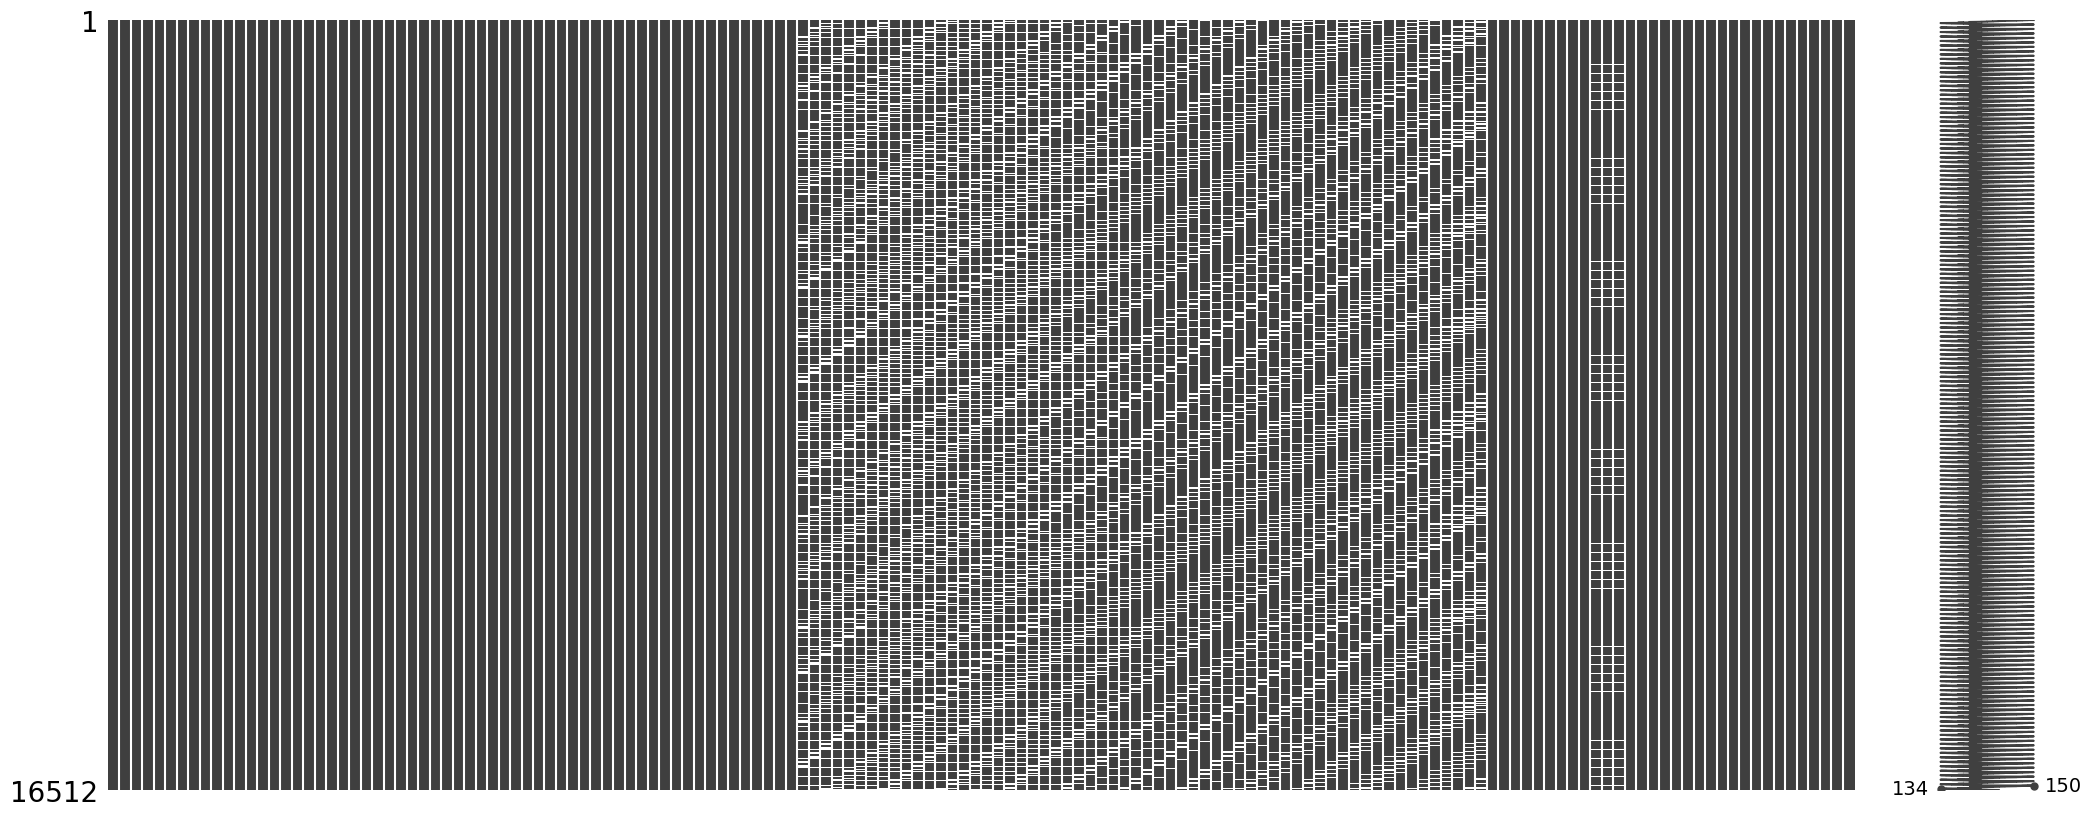

In [231]:
msno.matrix(basin_training_data_df)

### Saving resulting Dataframe

In [232]:
basin_training_data_df.to_csv('basin_training_data_df.csv', index= False)